<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación </h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
<h2>Mentoría: Detección de objetos en imágenes</h2>
</center>


En la siguiente notebook, incorporaremos parte de lo realizado en las entregas 1 de los grupos de estudiantes: 

* [Grupo 1](https://github.com/Ana1890/Deteccion-de-objetos-en-imagenes) : Ana Rusconi, Ignacio Grosso y  Mariano Lucero

* [Grupo 2](https://github.com/leorodriguez/mentoria-diplodatos-grupo2):  Diego Gonzalez, Florencia Caballero, Joel Vivas y Leonardo Rodriguez


#### <a name="generacion_tabla"></a>
#### **Análisis general del dataset**

En las entregas anteriores tuvieron la oportunidad de explorar una pequeña muestra de las imágenes para que el análisis sea mas representativo del conjunto de datos total, en esta entrega utilizaremos el dataset completo.

En esta notebook utilizaremos la tabla generada en'[5-Generación_de_fotos_recortadas_y_tabla-Aprendizaje_Supervisado](https://colab.research.google.com/drive/1fgB4F4DlBqkCvOatqo3whm4ZTPsiP0L7?usp=sharing)'

La carpeta con los datos, es compartida en el [Drive](https://drive.google.com/drive/folders/1-bl3h1g1WROMmz66A2h7t2n3leTjhYxH?usp=sharing) y en el desarrollo de esta entrega con las consignas, se utilizará la misma en el entorno de Colab, pero también estarán en el repositorio de Github de la mentoría, en la [carpeta del práctico](https://github.com/luciabarg/mentoria_img/tree/master/4-Aprendizaje%20Supervisado).

La siguiente notebook usa como entorno Colab:

In [1]:
#vinculamos el Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# librerías necesarias 
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

import warnings

In [3]:
#nos posicionamos en la carpeta con los datos
os.chdir('/content/drive/My Drive/Mentoria/crop')

#### <a name="generacion_tabla"></a>
#### **Análisis general de la tabla**

1.   Cuántas fotos originales hay? (no filas! fotos :) )
2.   Separar los tamaños 'P' y 'G'. Tratarlos como conjuntos de datos por separado. 
      


In [5]:
#leemos el archivo de la tabla:
df = pd.read_csv('csv_wlabels_all_df.csv', index_col=0)
df = df.drop(['Type'], axis=1)  # la eliminamos ya que es una división previa de los datos, que no utilizaremos en este caso.
print(df.shape)
df.sample(10, random_state=3)

(15197, 2060)


,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
9557,N_P_Trabajando_Manos_21_double_box1.jpg,991,1034,238,281,N,P,43,43,1849,no,mano,0.166749,0.000369,0.500339,0.161118,0.041200,0.050891,0.154553,0.665174,0.240267,0.063930,0.044336,0.000572,0.416764,0.128607,0.165866,0.016881,1.176032,0.500885,0.423700,0.004136,0.001698,0.005363,0.382926,0.064722,0.001852,0.132717,0.000000,0.428410,...,0.066333,0.087176,0.000000,0.013312,0.324448,2.212602,0.254734,0.008744,0.138865,0.300000,0.637594,0.011901,0.049460,0.401184,0.022595,0.254455,0.043723,0.005202,0.192478,0.027078,0.051933,0.080394,0.092898,0.327411,0.009868,0.395551,0.032066,0.142075,0.230676,0.023778,0.380805,0.353925,0.052473,0.000000,0.554330,0.005756,0.376848,0.028537,0.100253,0.036433
8161,M_P_Trabajando_Manos_212_double_box1.jpg,880,918,258,301,M,P,38,43,1634,no,mano,0.094885,0.393973,0.853267,0.312711,0.380859,0.052059,1.159755,0.621245,0.120896,0.120132,0.588762,0.096425,0.385329,0.947975,0.009237,0.083373,0.049205,0.403659,0.083462,0.257438,0.346773,0.460732,0.028708,0.519695,0.110040,0.153280,0.323635,0.355569,...,0.097187,0.493220,0.000000,0.180694,0.179303,1.504794,0.827729,0.508927,0.215846,0.122467,0.530595,0.000618,0.184455,0.559553,0.138175,0.213468,0.285104,1.144138,0.566711,0.327027,0.363412,0.137086,0.084912,0.550113,0.044434,0.088174,0.145719,0.207480,0.231592,0.045406,0.633448,0.592583,0.943662,0.152015,1.128203,0.067969,0.199953,0.100300,0.281108,0.089729
5635,N_G_Trabajando_Mano-Verde_46_double_box1.jpg,578,765,472,670,N,G,187,198,37026,no,mano,0.076630,0.195525,0.670454,0.543749,0.074252,0.143569,0.447257,0.563461,0.067730,0.366459,0.222867,0.024312,0.610457,0.176391,0.494002,0.000000,0.378354,0.309846,0.096114,0.058886,0.074333,0.644869,0.091968,0.012946,0.011972,0.273961,0.035408,0.631569,...,0.631352,0.067067,0.024235,0.744374,1.516535,0.982556,0.029389,0.254467,0.113976,1.211807,0.179858,0.108019,0.178976,0.127699,0.267270,0.678574,0.366752,0.179628,1.106947,0.314332,0.321207,0.090449,0.920505,0.215786,0.423265,0.271077,0.091856,0.049356,0.774448,0.046154,0.317865,0.558890,0.204547,0.052799,1.955935,0.217638,0.048785,0.104983,0.256886,0.493922
749,M_P_Mostrando_Amarillos_125_single_box.jpg,889,954,262,312,M,P,65,50,3250,si,Amarillo,0.379226,0.092820,0.696334,0.420878,0.058752,0.193275,1.037162,0.797642,0.436706,0.238679,0.253341,0.100714,0.826281,0.169469,0.042620,0.020347,0.027039,0.586334,0.820484,0.020155,0.066414,0.680729,0.307690,0.540089,0.028788,0.006838,0.116451,0.028838,...,0.024388,0.607517,0.000000,0.058582,1.045965,1.586019,0.680829,0.260793,0.532428,0.184467,0.569455,0.017816,0.295093,0.182839,0.524620,0.049728,0.108213,0.169538,1.371890,0.203499,0.072543,0.195590,0.018305,0.399330,0.358528,0.145473,0.079686,0.158050,0.369089,0.096154,0.720346,0.175028,0.565678,0.493365,1.011929,0.963899,0.295929,0.881299,0.671999,0.043974
15032,T_P_Trabajando_Verdes_214_double_box1.jpg,1164,1214,261,313,T,P,50,52,2600,si,Verde,0.199411,0.370708,2.506824,0.054657,0.029642,0.026988,0.527299,1.073092,0.327007,0.012425,0.014122,0.007214,0.777692,0.230170,0.295639,0.050787,0.474625,0.072169,0.512034,0.066426,0.010539,0.035002,0.032114,0.079099,0.119081,0.214217,0.046028,0.483078,...,0.104354,0.087941,0.004916,0.029836,0.158759,2.006639,0.163518,0.247811,0.290540,0.250749,0.409766,0.086800,0.305579,0.078313,0.131825,0.496930,0.121187,0.117308,0.591646,0.296019,0.247361,0.343462,0.059048,0.583142,0.263774,0.274130,0.000000,0.303564,0.472607,0.005136,0.161953,2.004744,0.129250,0.061128,0.676238,1.121648,0.661923,0.015143,0.215906,0.000741
11472,M_G_Mostrando_Verdes_164_double_box2.jpg,617,735,210,334,M,G,118,124,14632,si,Verde,1.711577,0.67593

### Creamos algunas agrupaciones para poder trabajar ordenadamente

In [6]:

#0          1      2    3     4     5     6           7                8           9      10     11   12
#filename	xmin	xmax	ymin	ymax	Time	Size	Hand_Pixel_Width	Hand_Pixel_Height	Area	guantes	color	 0	

# Distintas agrupaciones de columnas
image_descr_cols = [col for col in df.columns[0:5]]
categ_cols=['Time', 'Size', 'guantes','color']
size_cols = ['Hand_Pixel_Width', 'Hand_Pixel_Height', 'Area']
feature_cols = [col for col in df.columns[12:]]

non_feature_cols = image_descr_cols + size_cols + categ_cols
all_cols = non_feature_cols + feature_cols

df=df[all_cols]
df.sample(5, random_state=3).round(2)


,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
9557,N_P_Trabajando_Manos_21_double_box1.jpg,991,1034,238,281,43,43,1849,N,P,no,mano,0.17,0.00,0.50,0.16,0.04,0.05,0.15,0.67,0.24,0.06,0.04,0.00,0.42,0.13,0.17,0.02,1.18,0.50,0.42,0.00,0.00,0.01,0.38,0.06,0.00,0.13,0.00,0.43,...,0.07,0.09,0.00,0.01,0.32,2.21,0.25,0.01,0.14,0.30,0.64,0.01,0.05,0.40,0.02,0.25,0.04,0.01,0.19,0.03,0.05,0.08,0.09,0.33,0.01,0.40,0.03,0.14,0.23,0.02,0.38,0.35,0.05,0.00,0.55,0.01,0.38,0.03,0.10,0.04
8161,M_P_Trabajando_Manos_212_double_box1.jpg,880,918,258,301,38,43,1634,M,P,no,mano,0.09,0.39,0.85,0.31,0.38,0.05,1.16,0.62,0.12,0.12,0.59,0.10,0.39,0.95,0.01,0.08,0.05,0.40,0.08,0.26,0.35,0.46,0.03,0.52,0.11,0.15,0.32,0.36,...,0.10,0.49,0.00,0.18,0.18,1.50,0.83,0.51,0.22,0.12,0.53,0.00,0.18,0.56,0.14,0.21,0.29,1.14,0.57,0.33,0.36,0.14,0.08,0.55,0.04,0.09,0.15,0.21,0.23,0.05,0.63,0.59,0.94,0.15,1.13,0.07,0.20,0.10,0.28,0.09
5635,N_G_Trabajando_Mano-Verde_46_double_box1.jpg,578,765,472,670,187,198,37026,N,G,no,mano,0.08,0.20,0.67,0.54,0.07,0.14,0.45,0.56,0.07,0.37,0.22,0.02,0.61,0.18,0.49,0.00,0.38,0.31,0.10,0.06,0.07,0.64,0.09,0.01,0.01,0.27,0.04,0.63,...,0.63,0.07,0.02,0.74,1.52,0.98,0.03,0.25,0.11,1.21,0.18,0.11,0.18,0.13,0.27,0.68,0.37,0.18,1.11,0.31,0.32,0.09,0.92,0.22,0.42,0.27,0.09,0.05,0.77,0.05,0.32,0.56,0.20,0.05,1.96,0.22,0.05,0.10,0.26,0.49
749,M_P_Mostrando_Amarillos_125_single_box.jpg,889,954,262,312,65,50,3250,M,P,si,Amarillo,0.38,0.09,0.70,0.42,0.06,0.19,1.04,0.80,0.44,0.24,0.25,0.10,0.83,0.17,0.04,0.02,0.03,0.59,0.82,0.02,0.07,0.68,0.31,0.54,0.03,0.01,0.12,0.03,...,0.02,0.61,0.00,0.06,1.05,1.59,0.68,0.26,0.53,0.18,0.57,0.02,0.30,0.18,0.52,0.05,0.11,0.17,1.37,0.20,0.07,0.20,0.02,0.40,0.36,0.15,0.08,0.16,0.37,0.10,0.72,0.18,0.57,0.49,1.01,0.96,0.30,0.88,0.67,0.04
15032,T_P_Trabajando_Verdes_214_double_box1.jpg,1164,1214,261,313,50,52,2600,T,P,si,Verde,0.20,0.37,2.51,0.05,0.03,0.03,0.53,1.07,0.33,0.01,0.01,0.01,0.78,0.23,0.30,0.05,0.47,0.07,0.51,0.07,0.01,0.04,0.03,0.08,0.12,0.21,0.05,0.48,...,0.10,0.09,0.00,0.03,0.16,2.01,0.16,0.25,0.29,0.25,0.41,0.09,0.31,0.08,0.13,0.50,0.12,0.12,0.59,0.30,0.25,0.34,0.06,0.58,0.26,0.27,0.00,0.30,0.47,0.01,0.16,2.00,0.13,0.06,0.68,1.12,0.66,0.02,0.22,0.00


In [7]:
#Descripción del dataset
print(f'El dataset posee {df.shape[0]} filas x {df.shape[1]} columnas.\n')
print("Podemos clasificar las columnas en:\n")
print("Variables de descripción de la imagen:\n",df[image_descr_cols].columns,"\n",sep='')
print("Variables de tamaño de selección:\n",df[size_cols].columns,"\n", sep='')
print("Variables categóricas:\n",df[categ_cols].columns,"\n",sep='')
print("Variables de features propiamente dichos:\n",df[feature_cols].columns,"\n", sep='')

#Tipos de variables en el dataset
df.info()

El dataset posee 15197 filas x 2060 columnas.

Podemos clasificar las columnas en:

Variables de descripción de la imagen:
Index(['filename', 'xmin', 'xmax', 'ymin', 'ymax'], dtype='object')

Variables de tamaño de selección:
Index(['Hand_Pixel_Width', 'Hand_Pixel_Height', 'Area'], dtype='object')

Variables categóricas:
Index(['Time', 'Size', 'guantes', 'color'], dtype='object')

Variables de features propiamente dichos:
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2048)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15197 entries, 0 to 15196
Columns: 2060 entries, filename to 2047
dtypes: float64(2048), int64(7), object(5)
memory usage: 239.0+ MB


#### Analizamos algunos valores particulares

In [8]:
display(df.describe(percentiles=[.5]).rename(index={'50%': 'median'}).round(2))
display(df.describe(include='object'))

,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,...,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00,15197.00
mean,917.46,1044.35,260.58,379.45,126.89,118.87,20233.82,0.34,0.22,0.74,0.36,0.17,0.19,0.42,0.77,0.44,0.24,0.24,0.16,0.52,0.29,0.20,0.09,0.40,0.43,0.36,0.13,0.17,0.31,0.55,0.25,0.18,0.23,0.19,0.56,0.17,0.18,0.15,0.28,0.19,...,0.23,0.20,0.04,0.33,0.86,1.38,0.27,0.31,0.34,0.51,0.56,0.14,0.20,0.19,0.48,0.34,0.33,0.17,0.75,0.41,0.17,0.32,0.21,0.60,0.46,0.20,0.31,0.19,0.35,0.10,0.48,0.45,0.27,0.21,0.88,0.27,0.31,0.21,0.28,0.16
std,273.43,254.05,114.84,167.96,78.18,75.92,21513.28,0.32,0.22,0.55,0.27,0.17,0.21,0.31,0.43,0.31,0.19,0.24,0.24,0.43,0.23,0.18,0.11,0.42,0.28,0.30,0.18,0.20,0.25,0.44,0.26,0.23,0.21,0.20,0.40,0.18,0.17,0.16,0.28,0.19,...,0.25,0.16,0.06,0.36,0.71,0.64,0.25,0.26,0.29,0.37,0.32,0.17,0.17,0.13,0.50,0.28,0.31,0.18,0.56,0.31,0.18,0.22,0.23,0.38,0.40,0.19,0.35,0.21,0.23,0.12,0.30,0.45,0.29,0.23,0.51,0.24,0.27,0.19,0.34,0.18
min,0.00,259.00,0.00,33.00,18.00,18.00,475.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
median,938.00,1051.00,248.00,316.00,114.00,107.00,13832.00,0.24,0.16,0.61,0.30,0.12,0.11,0.35,0.70,0.37,0.19,0.17,0.08,0.40,0.23,0.15,0.06,0.26,0.38,0.28,0.07,0.11,0.26,0.43,0.18,0.11,0.18,0.13,0.47,0.11,0.13,0.09,0.20,0.14,...,0.15,0.16,0.01,0.22,0.66,1.35,0.19,0.24,0.26,0.44,0.52,0.09,0.16,0.16,0.33,0.27,0.24,0.11,0.61,0.34,0.11,0.27,0.13,0.53,0.38,0.15,0.19,0.12,0.30,0.06,0.42,0.31,0.18,0.13,0.79,0.21,0.24,0.16,0.17,0.10
max,1787.00,1863.00,966.00,1079.00,551.00,538.00,260623.00,3.64,2.06,5.11,2.34,1.61,2.32,2.60,3.18,2.60,1.50,1.99,2.83,3.75,2.39,1.72,1.04,3.51,2.46,3.00,2.25,3.11,2.31,3.32,2.69,3.07,1.98,1.83,3.28,2.56,1.42,1.57,2.59,1.69,...,2.33,1.34,0.69,3.98,4.23,4.41,2.09,2.32,2.61,3.55,2.21,1.99,1.59,0.93,4.23,2.78,3.10,1.91,3.49,2.63,1.58,1.78,2.25,3.21,2.87,1.89,3.61,2.84,1.91,1.64,2.96,5.04,2.63,2.38,3.47,1.89,2.41,1.63,3.70,1.54


,filename,Time,Size,guantes,color
count,15197,15197,15197,15197,15197
unique,15197,3,2,2,3
top,M_P_Trabajando_Amarillos_218_double_box1.jpg,M,G,si,mano
freq,1,5439,7790,9252,5945


In [9]:
print("Descripción del dataset (sin features):\n")
display(df[non_feature_cols].info())

print("\n\nDescripción del dataset (features):\n")
display(df[feature_cols].info())

Descripción del dataset (sin features):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15197 entries, 0 to 15196
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   filename           15197 non-null  object
 1   xmin               15197 non-null  int64 
 2   xmax               15197 non-null  int64 
 3   ymin               15197 non-null  int64 
 4   ymax               15197 non-null  int64 
 5   Hand_Pixel_Width   15197 non-null  int64 
 6   Hand_Pixel_Height  15197 non-null  int64 
 7   Area               15197 non-null  int64 
 8   Time               15197 non-null  object
 9   Size               15197 non-null  object
 10  guantes            15197 non-null  object
 11  color              15197 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.5+ MB


None



Descripción del dataset (features):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15197 entries, 0 to 15196
Columns: 2048 entries, 0 to 2047
dtypes: float64(2048)
memory usage: 237.6 MB


None

<br>

##Análisis de la variables categóricas y de tamaño de las imágenes


In [10]:
#Se detectan variables categóricas para identificar las clases que hay en nuestro dataset
print("Valores de las variables categóricas:\n")
for col in categ_cols:
  print(col, df[col].unique(),"\n")


Valores de las variables categóricas:

Time ['M' 'N' 'T'] 

Size ['G' 'P'] 

guantes ['si' 'no'] 

color ['Amarillo' 'Verde' 'mano'] 



#### Analizamos la presencia de valores nulos y filas duplicadas


In [11]:
# Verificamos si existen valores nulos
print("Columnas con algún valor nulo:",df.columns[df.isna().any()])

Columnas con algún valor nulo: Index([], dtype='object')


In [12]:
# Verificamos si hay filas completas duplicadas
df[df.duplicated()]

,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


In [13]:
# Verificamos si hay duplicados en el nombre
df[df.filename.duplicated()]

,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


In [14]:
# Verificamos si hay índices duplicados
df[df.index.duplicated()]

,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


No hay valores nulos, ni filas ni índices duplicados.

<br>

### Calculamos la cantidad de imágenes originales

#### Obtenemos los nombres de las imágenes usando el filename (eliminando la sección de box correspondiente a la selección de cada mano o guante)

In [15]:
#formato genérico del tipo de archivo
#filename pattern: Time_Size_Action_Color_Number_Box.Extension

# Nos quedamos sin la parte del box, que corresponde a la selección de manos y guantes dentro de la imagen.

original_filenames=df.filename.apply(lambda x: "_".join(x.split("_", 5)[:5])+".jpg")
original_filenames.drop_duplicates(keep='first', inplace=True)
original_filenames=original_filenames.sort_values(ignore_index=True)

print("Cantidad de imágenes originales (obtenidas del datafame):",len(original_filenames),"\n")
original_filenames

Cantidad de imágenes originales (obtenidas del datafame): 8509 



0         M_G_Mostrando_Amarillos_0.jpg
1         M_G_Mostrando_Amarillos_1.jpg
2        M_G_Mostrando_Amarillos_10.jpg
3       M_G_Mostrando_Amarillos_100.jpg
4       M_G_Mostrando_Amarillos_101.jpg
                     ...               
8504       T_P_Trabajando_Verdes_95.jpg
8505       T_P_Trabajando_Verdes_96.jpg
8506       T_P_Trabajando_Verdes_97.jpg
8507       T_P_Trabajando_Verdes_98.jpg
8508       T_P_Trabajando_Verdes_99.jpg
Name: filename, Length: 8509, dtype: object

Preguntas antes de entrenar los algoritmos:

*   Identifique las clases y cuántas hay de cada una (tanto binaria como multiclase). Hay desbalanceo? Si lo hubiera, cómo lo solucionarían? 

*   Un par de preguntas con respecto la separación de los datos:
     
     * Qué se hace con las columnas *'target'*? ('guantes' y 'color'). Hay columnas que pueden ser descartadas? Si quisiéramos aprovechar la información de las columnas descartadas, como podríamos hacerlo? 
    
* Para la variable target elegida, conviene dejarla así o hay que hacer alguna transformación?
* Conviene normalizar antes de pasar los datos al algoritmo?

### Separamos el dataset por tamaño de imagen

In [16]:
df_P = df[df.Size == 'P']
df_G = df[df.Size == 'G']

In [17]:
#Dimensiones de los dataset
[df_P.shape, df_G.shape]

[(7407, 2060), (7790, 2060)]

In [18]:
df_P.groupby(by=['guantes']).size()

guantes
no    2770
si    4637
dtype: int64

In [19]:
df_P.groupby(by=['guantes','color']).size()

guantes  color   
no       mano        2770
si       Amarillo    2293
         Verde       2344
dtype: int64

In [20]:
df_G.groupby(by='guantes').size()

guantes
no    3175
si    4615
dtype: int64

In [21]:
df_G.groupby(by=['guantes', 'color']).size()

guantes  color   
no       mano        3175
si       Amarillo    2399
         Verde       2216
dtype: int64

* Podemos ver que en ambos grupos los datos no se encuentran desbalanceados en lo que respecta a las clases de 'guantes' y/o 'color'. Sin embargo, si hubiera aparecido un desbalanceo entre los datos se podría agregar con técnicas de aumentación de datos más datos que representen a la clase que está desbalanceada. También podríamos aportarle más peso a esta clase cuando definamos nuestros modelos de predicción.

* Podríamos descartar del dataset aquellas columnas que no son el target. Sin embargo, podemos realizar una exploración del comportamiento entre estas etiquetas y otras columnas categóricas para poder detectar si nos pueden aportar más información. Por ejemplo, el área nos podría indicar qué tan grandes son nuestros objetos, y por lo tanto está relacionada con la característica de Size, independientemente si hay guantes o no, aunque el tamaño nos puede indicar si será difícil o no predecir. 

* La variable target conviene codificarla a un número entero, puesto que de esta manera es como indentifican los modelos al target. Algunos modelos de clasificación necesitan que los datos de entrada se encuentren en un determinado tipo de dato, y otros requieren o suponen que las variables tienen una media de 0. Por lo tanto conviene normalizar los datos antes de que se ingresen a los modelos de clasificación.

### Entrenamiento de algoritmos para generar un modelo:

* Separar los datos 'P' y 'G' en conjuntos de test y entrenamiento en un 70-30. Recordar que tenemos para hacer tanto clasificación binaria como multiclase.

* Entrenar los algoritmos de clasificación KNN, SMV y Random Forest:
  * Entrenar el modelo sin parámetros y tomarlo como baseline. Revisar documentación para identificar los parámetros correspondientes.
  * Utilizar CV para encontrar los parámetros para encontrar el mejor modelo de cada uno de ellos. (Cuál métrica van a utilizar? Porqué eligen esa en particular? Se puede utilizar la misma métrica para toda clase de datos? )
  * Hacer una tabla para comparar los mejores modelos de cada algoritmo. 
  * Visualizar los resultados por medio de:
    *  Matriz de Confusión
    *  Reporte de Clasificación
  * Recordar de documentar los pasos que están llevando a cabo, comentar el código, plantear inconvenientes y contar lo que encontraron, poner conclusiones :).
  
  Opcional: 
  * Graficar la métrica elegida con respecto al cambio de los parámetros de los conjuntos 'test' y 'train'.
  * Generar las Curvas de ROC correspondientes para los mejores modelos de clasificación binaria.
  * Podemos utilizar los mejores modelos para generar uno mas mejor? :P
  (chusmear: ['Ensembles'](https://www.iartificial.net/ensembles-voting-bagging-boosting-stacking/) )

---

### Convertimos las columnas categóricas a predecir a formato numérico para poder aplicar luego los algoritmos de aprendizaje

In [22]:
le_g = LabelEncoder()
le_g.fit(df.guantes)
df.guantes = le_g.transform(df.guantes)
display(list(le_g.classes_))
display(list(le_g.inverse_transform([0, 1])))

le_c = LabelEncoder()
le_c.fit(df.color)
df.color = le_c.transform(df.color)
display(list(le_c.classes_))
display(list(le_c.inverse_transform([0,1,2])))

['no', 'si']

['no', 'si']

['Amarillo', 'Verde', 'mano']

['Amarillo', 'Verde', 'mano']

### Estandarizamos (scaling) las variables correspondientes a features del dataset, ya que la mayoría de los algoritmos funcionan mejor de esta forma

#### Decidimos aplicar el scaling sobre todo el dataset, ya que test y train es sacado del mismo. En caso de tener nuevos datos de test hay que aplicarles la función *scaler.transform* generada antes de  poder ser usados en el modelo.

In [23]:
print("Dataset con features sin estandarizar:\n")
display(df.sample(3,random_state=3))

scaler = MinMaxScaler()
df.loc[:,feature_cols]=scaler.fit_transform(df[feature_cols])

print("\nDataset con features estandarizadas:\n")
display(df.sample(3,random_state=3))

Dataset con features sin estandarizar:



,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
9557,N_P_Trabajando_Manos_21_double_box1.jpg,991,1034,238,281,43,43,1849,N,P,0,2,0.166749,0.000369,0.500339,0.161118,0.041200,0.050891,0.154553,0.665174,0.240267,0.063930,0.044336,0.000572,0.416764,0.128607,0.165866,0.016881,1.176032,0.500885,0.423700,0.004136,0.001698,0.005363,0.382926,0.064722,0.001852,0.132717,0.000000,0.428410,...,0.066333,0.087176,0.000000,0.013312,0.324448,2.212602,0.254734,0.008744,0.138865,0.300000,0.637594,0.011901,0.049460,0.401184,0.022595,0.254455,0.043723,0.005202,0.192478,0.027078,0.051933,0.080394,0.092898,0.327411,0.009868,0.395551,0.032066,0.142075,0.230676,0.023778,0.380805,0.353925,0.052473,0.000000,0.554330,0.005756,0.376848,0.028537,0.100253,0.036433
8161,M_P_Trabajando_Manos_212_double_box1.jpg,880,918,258,301,38,43,1634,M,P,0,2,0.094885,0.393973,0.853267,0.312711,0.380859,0.052059,1.159755,0.621245,0.120896,0.120132,0.588762,0.096425,0.385329,0.947975,0.009237,0.083373,0.049205,0.403659,0.083462,0.257438,0.346773,0.460732,0.028708,0.519695,0.110040,0.153280,0.323635,0.355569,...,0.097187,0.493220,0.000000,0.180694,0.179303,1.504794,0.827729,0.508927,0.215846,0.122467,0.530595,0.000618,0.184455,0.559553,0.138175,0.213468,0.285104,1.144138,0.566711,0.327027,0.363412,0.137086,0.084912,0.550113,0.044434,0.088174,0.145719,0.207480,0.231592,0.045406,0.633448,0.592583,0.943662,0.152015,1.128203,0.067969,0.199953,0.100300,0.281108,0.089729
5635,N_G_Trabajando_Mano-Verde_46_double_box1.jpg,578,765,472,670,187,198,37026,N,G,0,2,0.076630,0.195525,0.670454,0.543749,0.074252,0.143569,0.447257,0.563461,0.067730,0.366459,0.222867,0.024312,0.610457,0.176391,0.494002,0.000000,0.378354,0.309846,0.096114,0.058886,0.074333,0.644869,0.091968,0.012946,0.011972,0.273961,0.035408,0.631569,...,0.631352,0.067067,0.024235,0.744374,1.516535,0.982556,0.029389,0.254467,0.113976,1.211807,0.179858,0.108019,0.178976,0.127699,0.267270,0.678574,0.366752,0.179628,1.106947,0.314332,0.321207,0.090449,0.920505,0.215786,0.423265,0.271077,0.091856,0.049356,0.774448,0.046154,0.317865,0.558890,0.204547,0.052799,1.955935,0.217638,0.048785,0.104983,0.256886,0.493922



Dataset con features estandarizadas:



,filename,xmin,xmax,ymin,ymax,Hand_Pixel_Width,Hand_Pixel_Height,Area,Time,Size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
9557,N_P_Trabajando_Manos_21_double_box1.jpg,991,1034,238,281,43,43,1849,N,P,0,2,0.045780,0.000179,0.097993,0.068714,0.025565,0.021910,0.059479,0.207951,0.092252,0.042706,0.022268,0.000202,0.111207,0.053876,0.096470,0.016254,0.334906,0.203628,0.141454,0.001837,0.000547,0.002324,0.115371,0.024077,0.000603,0.066978,0.000000,0.130763,...,0.028418,0.065014,0.000000,0.003348,0.076777,0.500967,0.121854,0.003771,0.053193,0.084615,0.289018,0.005993,0.031027,0.433510,0.005339,0.091543,0.014123,0.002722,0.055076,0.010305,0.032778,0.045074,0.041278,0.102121,0.003441,0.209433,0.008879,0.050113,0.120571,0.014480,0.127969,0.070233,0.019980,0.000000,0.158389,0.003048,0.156183,0.017459,0.027116,0.023728
8161,M_P_Trabajando_Manos_212_double_box1.jpg,880,918,258,301,38,43,1634,M,P,0,2,0.026050,0.191342,0.167115,0.133366,0.236333,0.022413,0.446327,0.194090,0.046419,0.080249,0.295708,0.034015,0.102819,0.397126,0.005373,0.080273,0.014012,0.164102,0.027864,0.114305,0.111672,0.199683,0.008649,0.193332,0.035808,0.077356,0.177316,0.108530,...,0.041636,0.367837,0.000000,0.045449,0.042430,0.340161,0.395951,0.219484,0.082682,0.034542,0.240516,0.000311,0.115711,0.604639,0.032648,0.076797,0.092090,0.598729,0.162160,0.124450,0.229371,0.076859,0.037730,0.171583,0.015495,0.046685,0.040350,0.073183,0.121049,0.027650,0.213442,0.117592,0.359324,0.063932,0.324022,0.035990,0.082870,0.061363,0.076034,0.058437
5635,N_G_Trabajando_Mano-Verde_46_double_box1.jpg,578,765,472,670,187,198,37026,N,G,0,2,0.021038,0.094961,0.131310,0.231900,0.046075,0.061811,0.172125,0.175858,0.026005,0.244797,0.111936,0.008576,0.162891,0.073894,0.287318,0.000000,0.107746,0.125964,0.032088,0.026146,0.023938,0.279489,0.027709,0.004816,0.003896,0.138260,0.019400,0.192773,...,0.270477,0.050017,0.035053,0.187230,0.358874,0.221515,0.014059,0.109743,0.043660,0.341789,0.081529,0.054398,0.112274,0.137988,0.063151,0.244124,0.118463,0.093999,0.316744,0.119619,0.202733,0.050711,0.409015,0.067305,0.147599,0.143527,0.025435,0.017409,0.404791,0.028106,0.106675,0.110906,0.077887,0.022205,0.562924,0.115242,0.020219,0.064228,0.069482,0.321674


<br>

## Funciones generales de presentación de resultados

In [24]:
def print_metrics(y_true, y_pred):
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred),"\n\n")

def print_confusion_matrix(clf, X_train, y_train, X_test, y_test):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle('Matrices de confusión')
    axs[0].title.set_text('Entrenamiento')
    axs[1].title.set_text('Evaluación')
    fig.tight_layout(pad=5.0)

    p1=plot_confusion_matrix(clf, X_train, y_train, ax=axs[0], cmap=plt.cm.Blues, values_format='d')
    p2=plot_confusion_matrix(clf, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, values_format='d')

    plt.show()

def print_important_features(clf, X):
    if isinstance(clf, RandomForestClassifier):
      print("\n\nFeatures que mas influyeron en el aprendizaje del algoritmo:\n")
      feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

      # Creating a bar plot
      %matplotlib inline
      plt.figure(figsize=(7,7))
      sns.barplot(x=feature_imp.head(10), y=feature_imp.head(10).index)

      plt.xlabel('Feature Importance Score')
      plt.ylabel('Features')
      plt.title('Visualizing Important Features')
      plt.show()

def beautify_results(df):
    df.columns = [re.sub('param_*', '', x) for x in df.columns.values]
    df.rename(columns={'mean_test_score': 'mean_accuracy', 'std_test_score': 'standard_deviation', 'rank_test_score': 'rank'}, inplace = True)


<br>

## Funciones generales de ejecución de modelos

In [25]:
def process_default_model(clf, X, y, p=0.3):
  # Split dataset into training set and test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p, random_state=42) # 70% training and 30% test

  #Train the model using the training sets y_pred=clf.predict(X_test)
  clf.fit(X_train,y_train)

  y_train_pred = clf.predict(X_train)
  print("Metricas sobre el conjunto de entrenamiento:")
  print_metrics(y_train, y_train_pred)

  y_test_pred = clf.predict(X_test)

  # Model Accuracy, how often is the classifier correct?
  print("Accuracy de evaluación:",accuracy_score(y_test, y_test_pred))

  print("\nMétricas sobre el conjunto de evaluación:\n")
  print_metrics(y_test, y_test_pred)

  print_confusion_matrix(clf, X_train, y_train, X_test, y_test)
  print_important_features(clf, X)


In [35]:
def process_customized_model(clf, param, X, y, p=0.3):
  # Split dataset into training set and test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p, random_state=42) # 70% training and 30% test

  cv = GridSearchCV(clf, param, scoring='accuracy', cv=3, n_jobs=-1)
  cv.fit(X_train, y_train)
  display(cv)

  #Métricas del modelo con parámetros personalizados
  df=pd.DataFrame(cv.cv_results_)
  beautify_results(df)
  
  print("\n\nTabla comparativa de parámetros del modelo:\n")
  display(df[list(param.keys()) + ['mean_accuracy','standard_deviation','rank']].sort_values(by='rank').head(10))

  #Mejor estimador encontrado
  print("\nMejor estimador:\n",cv.best_estimator_,"\n")
  print("\nMejor resultado (accuracy):",cv.best_score_,"\n")

  #Evaluamos el modelo usando el mejor estimador
  y_train_pred = cv.predict(X_train)
  print('\nMetricas sobre el conjunto de entrenamiento: \n')
  print_metrics(y_train, y_train_pred)

  y_test_pred = cv.predict(X_test)
  print("\nMetricas sobre el conjunto de evaluación:")
  print_metrics(y_test, y_test_pred)

  print_confusion_matrix(cv, X_train, y_train, X_test, y_test)
  print_important_features(cv, X)


<br>

### Generamos los conjuntos de datos ***X*** y target ***y*** para los datasets G y P

In [27]:
# IMÁGENES GRANDES
X_G = df_G[feature_cols]
y_G_guantes = df_G['guantes']
y_G_color   = df_G['color']

# IMÁGENES PEQUEÑAS
X_P = df_P[feature_cols]
y_P_guantes = df_P['guantes']
y_P_color   = df_P['color']

<br>

# KNN

## KNN - Modelo por Defecto

In [34]:
print("\nMODELO KNN CON PARÁMETROS POR DEFECTO:\n\n",KNeighborsClassifier().get_params)


MODELO KNN CON PARÁMETROS POR DEFECTO:

 <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>




CLASIFICADOR IMÁGENES GRANDES - GUANTES

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      0.989     0.983     0.986      2206
          si      0.988     0.993     0.990      3247

    accuracy                          0.989      5453
   macro avg      0.989     0.988     0.988      5453
weighted avg      0.989     0.989     0.989      5453

Confusion matrix:
 [[2168   38]
 [  24 3223]] 


Accuracy de evaluación: 0.9781771501925546

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.973     0.974     0.974       969
          si      0.982     0.981     0.981      1368

    accuracy                          0.978      2337
   macro avg      0.977     0.978     0.978      2337
weighted avg      0.978     0.978     0.978      2337

Confusion matrix:
 [[ 944   25]
 [  26 1342]] 




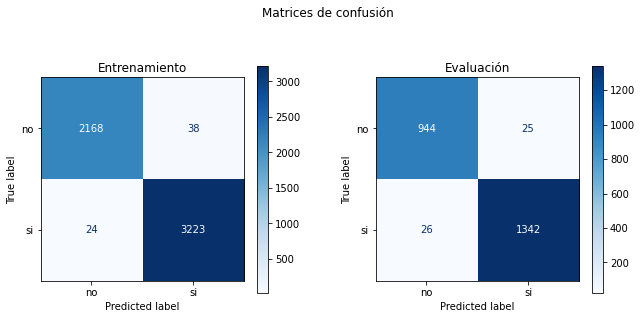



CLASIFICADOR IMÁGENES GRANDES - COLOR

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      0.979     0.981     0.980      1651
       Verde      0.978     0.984     0.981      1596
        mano      0.989     0.983     0.986      2206

    accuracy                          0.983      5453
   macro avg      0.982     0.983     0.982      5453
weighted avg      0.983     0.983     0.983      5453

Confusion matrix:
 [[1620   19   12]
 [  14 1570   12]
 [  21   17 2168]] 


Accuracy de evaluación: 0.9653401797175867

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.964     0.961     0.963       748
       Verde      0.955     0.956     0.956       620
        mano      0.973     0.974     0.974       969

    accuracy                          0.965      2337
   macro avg      0.964     0.964     0.964      2337
weighted avg      0.965     0.965     0.965

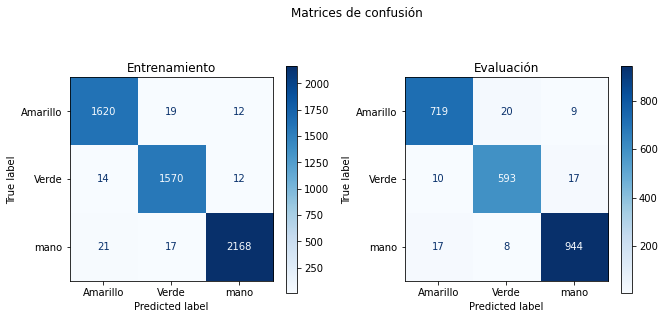



CLASIFICADOR IMÁGENES PEQUEÑAS - GUANTES


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      0.923     0.814     0.865      1977
          si      0.893     0.958     0.924      3207

    accuracy                          0.903      5184
   macro avg      0.908     0.886     0.895      5184
weighted avg      0.904     0.903     0.902      5184

Confusion matrix:
 [[1610  367]
 [ 135 3072]] 


Accuracy de evaluación: 0.8529014844804319

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.839     0.728     0.779       793
          si      0.859     0.922     0.890      1430

    accuracy                          0.853      2223
   macro avg      0.849     0.825     0.834      2223
weighted avg      0.852     0.853     0.850      2223

Confusion matrix:
 [[ 577  216]
 [ 111 1319]] 




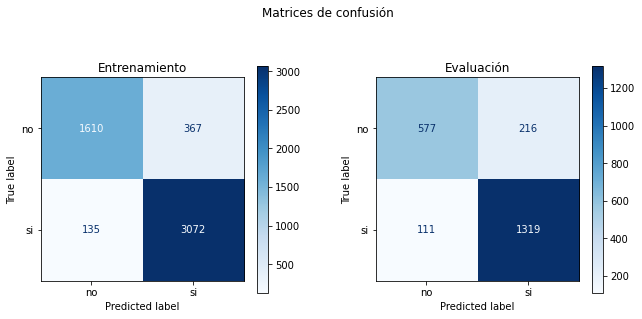



CLASIFICADOR IMÁGENES PEQUEÑAS - COLOR


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      0.874     0.919     0.896      1579
       Verde      0.826     0.903     0.863      1628
        mano      0.923     0.814     0.865      1977

    accuracy                          0.874      5184
   macro avg      0.874     0.879     0.875      5184
weighted avg      0.878     0.874     0.874      5184

Confusion matrix:
 [[1451   74   54]
 [  77 1470   81]
 [ 132  235 1610]] 


Accuracy de evaluación: 0.8047683310841206

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.812     0.861     0.836       714
       Verde      0.767     0.834     0.799       716
        mano      0.839     0.728     0.779       793

    accuracy                          0.805      2223
   macro avg      0.806     0.808     0.805      2223
weighted avg      0.807     0.805     0.8

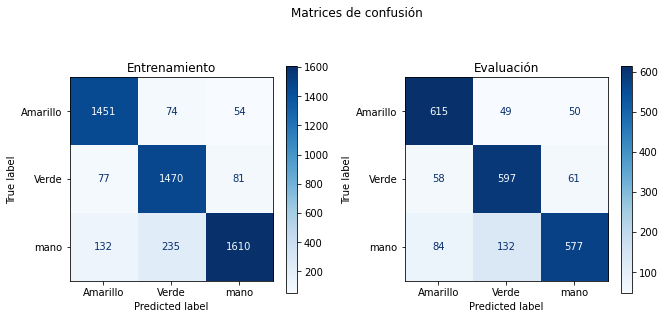

In [ ]:
print("\n\nCLASIFICADOR KNN PARA IMÁGENES GRANDES - GUANTES\n")
process_default_model(KNeighborsClassifier(), X_G, y_G_guantes) # Accuracy: 0.9781771501925546

print("\n\nCLASIFICADOR KNN PARA IMÁGENES GRANDES - COLOR\n")
process_default_model(KNeighborsClassifier(), X_G, y_G_color)   # Accuracy: 0.9653401797175867

print("\n\nCLASIFICADOR KNN PARA IMÁGENES PEQUEÑAS - GUANTES\n\n")
process_default_model(KNeighborsClassifier(), X_P, y_P_guantes) # Accuracy: 0.8529014844804319

print("\n\nCLASIFICADOR KNN PARA IMÁGENES PEQUEÑAS - COLOR\n\n")
process_default_model(KNeighborsClassifier(), X_P, y_P_color)   # Accuracy: 0.8047683310841206


## KNN - Modelo Personalizado



CLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES GRANDES - GUANTES



GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,n_neighbors,weights,metric,mean_accuracy,standar_deviation,rank
25,9,distance,minkowski,0.975427,0.001125,1
5,9,distance,euclidean,0.975427,0.001125,1
27,11,distance,minkowski,0.975242,0.002952,3
7,11,distance,euclidean,0.975242,0.002952,3
24,9,uniform,minkowski,0.974143,0.000443,5
4,9,uniform,euclidean,0.974143,0.000443,5
23,7,distance,minkowski,0.974142,0.002252,7
3,7,distance,euclidean,0.974142,0.002252,7
26,11,uniform,minkowski,0.973958,0.003496,9
6,11,uniform,euclidean,0.973958,0.003496,9



Mejor estimador:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='distance') 


Mejor resultado (accuracy): 0.9754266382426171 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      1.000     1.000     1.000      2206
          si      1.000     1.000     1.000      3247

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[2206    0]
 [   0 3247]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

          no      0.973     0.972     0.973       969
          si      0.980     0.981     0.981      1368

    accuracy                          0.977      2337
   macro avg      0.977     0.977     0.977      2337
weig

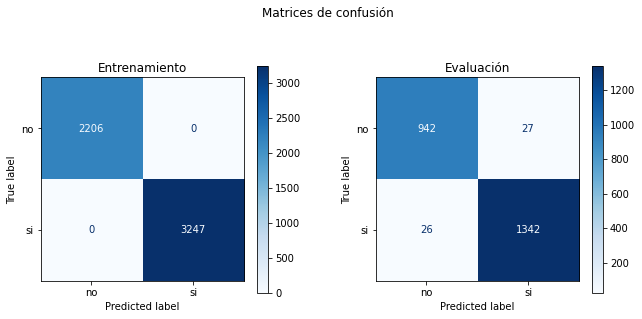



CLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES GRANDES - COLOR



GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,n_neighbors,weights,metric,mean_accuracy,standar_deviation,rank
23,7,distance,minkowski,0.961306,0.002466,1
3,7,distance,euclidean,0.961306,0.002466,1
25,9,distance,minkowski,0.960940,0.002492,3
5,9,distance,euclidean,0.960940,0.002492,3
9,15,distance,euclidean,0.960939,0.001179,5
29,15,distance,minkowski,0.960939,0.001179,5
21,5,distance,minkowski,0.960756,0.006093,7
1,5,distance,euclidean,0.960756,0.006093,7
7,11,distance,euclidean,0.960572,0.001694,9
27,11,distance,minkowski,0.960572,0.001694,9



Mejor estimador:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='distance') 


Mejor resultado (accuracy): 0.9613062388609069 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1651
       Verde      1.000     1.000     1.000      1596
        mano      1.000     1.000     1.000      2206

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[1651    0    0]
 [   0 1596    0]
 [   0    0 2206]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

    Amarillo      0.976     0.964     0.970       748
       Verde      0.958     0.960     0.959       620
        mano      0.970     0.9

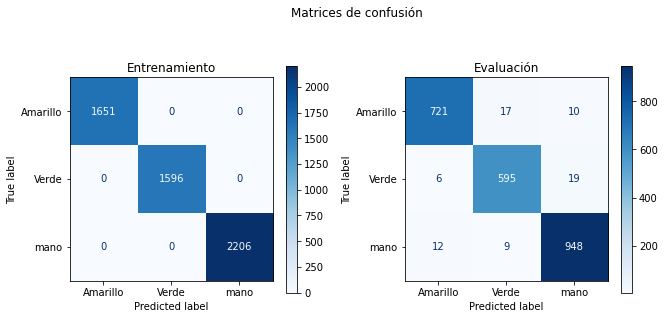



CLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES PEQUEÑAS - GUANTES



GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,n_neighbors,weights,metric,mean_accuracy,standar_deviation,rank
25,9,distance,minkowski,0.835262,0.007798,1
3,7,distance,euclidean,0.835262,0.005637,1
5,9,distance,euclidean,0.835262,0.007798,1
17,11,distance,manhattan,0.835262,0.005637,1
23,7,distance,minkowski,0.835262,0.005637,1
27,11,distance,minkowski,0.834877,0.008051,6
7,11,distance,euclidean,0.834877,0.008051,6
2,7,uniform,euclidean,0.834684,0.006020,8
22,7,uniform,minkowski,0.834684,0.006020,8
15,9,distance,manhattan,0.834684,0.003848,10



Mejor estimador:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='distance') 


Mejor resultado (accuracy): 0.8352623456790124 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      1.000     1.000     1.000      1977
          si      1.000     1.000     1.000      3207

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighted avg      1.000     1.000     1.000      5184

Confusion matrix:
 [[1977    0]
 [   0 3207]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

          no      0.861     0.702     0.774       793
          si      0.850     0.937     0.892      1430

    accuracy                          0.853      2223
   macro avg      0.856     0.820     0.833      2223
weig

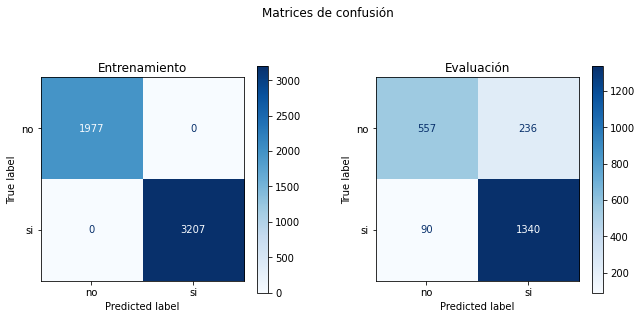



CLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES PEQUEÑAS - COLOR



GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,n_neighbors,weights,metric,mean_accuracy,standar_deviation,rank
17,11,distance,manhattan,0.793403,0.008661,1
11,5,distance,manhattan,0.790123,0.013242,2
15,9,distance,manhattan,0.789352,0.009126,3
13,7,distance,manhattan,0.789159,0.014428,4
19,15,distance,manhattan,0.788773,0.011982,5
5,9,distance,euclidean,0.788580,0.007233,6
25,9,distance,minkowski,0.788580,0.007233,6
27,11,distance,minkowski,0.788002,0.009166,8
7,11,distance,euclidean,0.788002,0.009166,8
3,7,distance,euclidean,0.787616,0.008360,10



Mejor estimador:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='distance') 


Mejor resultado (accuracy): 0.7934027777777777 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1579
       Verde      1.000     1.000     1.000      1628
        mano      1.000     1.000     1.000      1977

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighted avg      1.000     1.000     1.000      5184

Confusion matrix:
 [[1579    0    0]
 [   0 1628    0]
 [   0    0 1977]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

    Amarillo      0.862     0.825     0.843       714
       Verde      0.775     0.842     0.807       716
        mano      0.818     0.

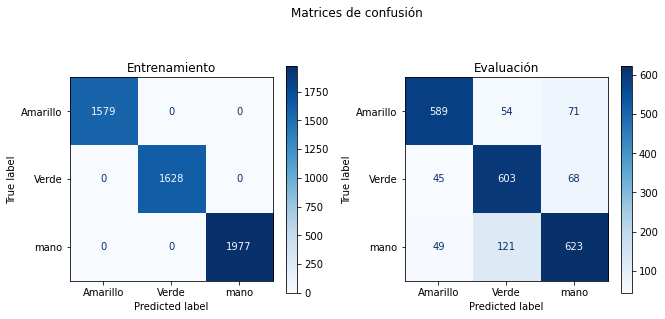

In [29]:
knn_parameters = {
    'n_neighbors': [5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    print("\n\nCLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES GRANDES - GUANTES\n")
    process_customized_model(KNeighborsClassifier(n_jobs=-1), knn_parameters, X_G, y_G_guantes) # Accuracy: 0.9754266382426171

    print("\n\nCLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES GRANDES - COLOR\n")
    process_customized_model(KNeighborsClassifier(n_jobs=-1), knn_parameters, X_G, y_G_color)   # Accuracy: 0.9613062388609069

    print("\n\nCLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES PEQUEÑAS - GUANTES\n")
    process_customized_model(KNeighborsClassifier(n_jobs=-1), knn_parameters, X_P, y_P_guantes) # Accuracy: 0.8352623456790124

    print("\n\nCLASIFICADOR KNN PERSONALIZADO PARA IMÁGENES PEQUEÑAS - COLOR\n")
    process_customized_model(KNeighborsClassifier(n_jobs=-1), knn_parameters, X_P, y_P_color)   # Accuracy: 0.7934027777777777


<br>

# SVM



## SVM - Modelo por Defecto

In [32]:
print("\nMODELO SVC CON PARÁMETROS POR DEFECTO:\n\n",SVC(random_state=11).get_params)


MODELO SVC CON PARÁMETROS POR DEFECTO:

 <bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=11, shrinking=True, tol=0.001,
    verbose=False)>




CLASIFICADOR IMÁGENES GRANDES - GUANTES

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      0.996     0.995     0.995      2206
          si      0.996     0.998     0.997      3247

    accuracy                          0.996      5453
   macro avg      0.996     0.996     0.996      5453
weighted avg      0.996     0.996     0.996      5453

Confusion matrix:
 [[2194   12]
 [   8 3239]] 


Accuracy de evaluación: 0.9888746255883611

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.986     0.988     0.987       969
          si      0.991     0.990     0.990      1368

    accuracy                          0.989      2337
   macro avg      0.988     0.989     0.989      2337
weighted avg      0.989     0.989     0.989      2337

Confusion matrix:
 [[ 957   12]
 [  14 1354]] 




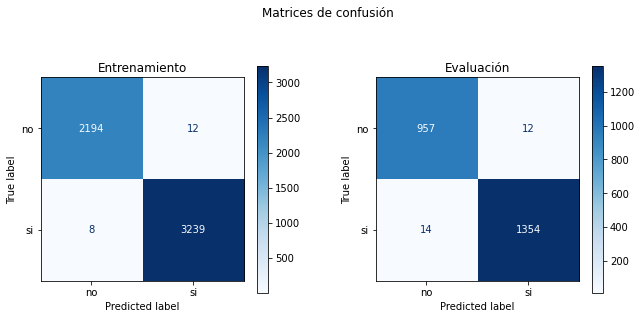



CLASIFICADOR IMÁGENES GRANDES - COLOR

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      0.995     0.993     0.994      1651
       Verde      0.997     0.996     0.996      1596
        mano      0.995     0.997     0.996      2206

    accuracy                          0.996      5453
   macro avg      0.996     0.995     0.996      5453
weighted avg      0.996     0.996     0.996      5453

Confusion matrix:
 [[1640    5    6]
 [   2 1589    5]
 [   6    0 2200]] 


Accuracy de evaluación: 0.9871630295250321

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.991     0.991     0.991       748
       Verde      0.992     0.977     0.985       620
        mano      0.982     0.991     0.986       969

    accuracy                          0.987      2337
   macro avg      0.988     0.986     0.987      2337
weighted avg      0.987     0.987     0.987

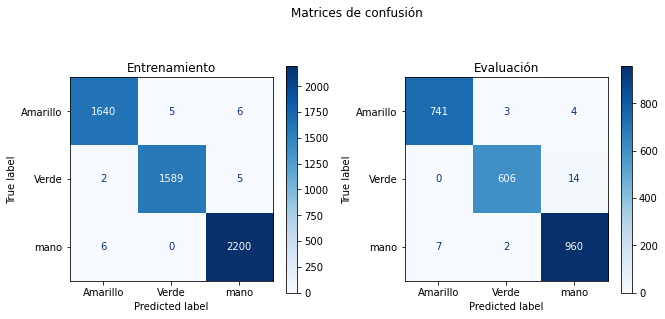



CLASIFICADOR IMÁGENES PEQUEÑAS - GUANTES


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      0.951     0.873     0.910      1977
          si      0.925     0.972     0.948      3207

    accuracy                          0.934      5184
   macro avg      0.938     0.922     0.929      5184
weighted avg      0.935     0.934     0.934      5184

Confusion matrix:
 [[1725  252]
 [  89 3118]] 


Accuracy de evaluación: 0.9194781826360774

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.932     0.835     0.881       793
          si      0.913     0.966     0.939      1430

    accuracy                          0.919      2223
   macro avg      0.923     0.901     0.910      2223
weighted avg      0.920     0.919     0.918      2223

Confusion matrix:
 [[ 662  131]
 [  48 1382]] 




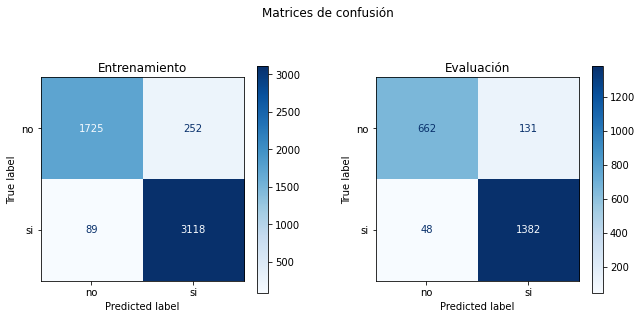



CLASIFICADOR IMÁGENES PEQUEÑAS - COLOR


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      0.951     0.920     0.935      1579
       Verde      0.886     0.918     0.902      1628
        mano      0.922     0.918     0.920      1977

    accuracy                          0.919      5184
   macro avg      0.920     0.919     0.919      5184
weighted avg      0.919     0.919     0.919      5184

Confusion matrix:
 [[1453   67   59]
 [  38 1495   95]
 [  37  125 1815]] 


Accuracy de evaluación: 0.8915879442195231

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.918     0.888     0.902       714
       Verde      0.855     0.904     0.878       716
        mano      0.905     0.884     0.894       793

    accuracy                          0.892      2223
   macro avg      0.892     0.892     0.892      2223
weighted avg      0.893     0.892     0.8

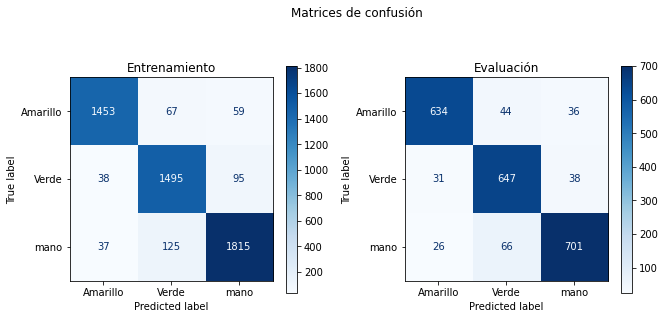

In [34]:
print("\n\nCLASIFICADOR SVC PARA IMÁGENES GRANDES - GUANTES\n")
process_default_model(SVC(random_state=11), X_G, y_G_guantes) # Accuracy: 0.9888746255883611

print("\n\nCLASIFICADOR SVC PARA IMÁGENES GRANDES - COLOR\n")
process_default_model(SVC(random_state=11), X_G, y_G_color)   # Accuracy: 0.9871630295250321

print("\n\nCLASIFICADOR SVC PARA IMÁGENES PEQUEÑAS - GUANTES\n\n")
process_default_model(SVC(random_state=11), X_P, y_P_guantes) # Accuracy: 0.9194781826360774

print("\n\nCLASIFICADOR SVC PARA IMÁGENES PEQUEÑAS - COLOR\n\n")
process_default_model(SVC(random_state=11), X_P, y_P_color)   # Accuracy: 0.8915879442195231


## SVM - Modelo Personalizado



CLASIFICADOR SVC IMÁGENES GRANDES - GUANTES



GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=11, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 100.0], 'degree': [3, 5],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,C,gamma,degree,mean_accuracy,standar_deviation,rank
8,100,scale,3,0.991747,0.002335,1
10,100,scale,5,0.991747,0.002335,1
4,10,scale,3,0.991564,0.002475,3
6,10,scale,5,0.991564,0.002475,3
9,100,auto,3,0.990280,0.002305,5
11,100,auto,5,0.990280,0.002305,5
0,1,scale,3,0.990097,0.002246,7
2,1,scale,5,0.990097,0.002246,7
5,10,auto,3,0.989914,0.002215,9
7,10,auto,5,0.989914,0.002215,9



Mejor estimador:
 SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=11, shrinking=True, tol=0.001,
    verbose=False) 


Mejor resultado (accuracy): 0.9917473585553381 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      1.000     1.000     1.000      2206
          si      1.000     1.000     1.000      3247

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[2206    0]
 [   0 3247]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

          no      0.988     0.991     0.989       969
          si      0.993     0.991     0.992      1368

    accuracy                          0.991     

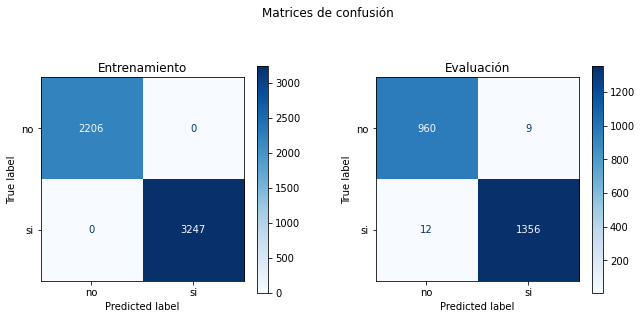



CLASIFICADOR SVC IMÁGENES GRANDES - COLOR



GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=11, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 100.0], 'degree': [3, 5],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,C,gamma,degree,mean_accuracy,standar_deviation,rank
4,10,scale,3,0.988814,0.001577,1
6,10,scale,5,0.988814,0.001577,1
8,100,scale,3,0.988814,0.001577,1
10,100,scale,5,0.988814,0.001577,1
5,10,auto,3,0.986430,0.002073,5
7,10,auto,5,0.986430,0.002073,5
0,1,scale,3,0.986063,0.002120,7
2,1,scale,5,0.986063,0.002120,7
9,100,auto,3,0.986063,0.001869,9
11,100,auto,5,0.986063,0.001869,9



Mejor estimador:
 SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=11, shrinking=True, tol=0.001,
    verbose=False) 


Mejor resultado (accuracy): 0.9888135300413182 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1651
       Verde      1.000     1.000     1.000      1596
        mano      1.000     1.000     1.000      2206

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[1651    0    0]
 [   0 1596    0]
 [   0    0 2206]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

    Amarillo      0.997     0.993     0.995       748
       Verde      0.99

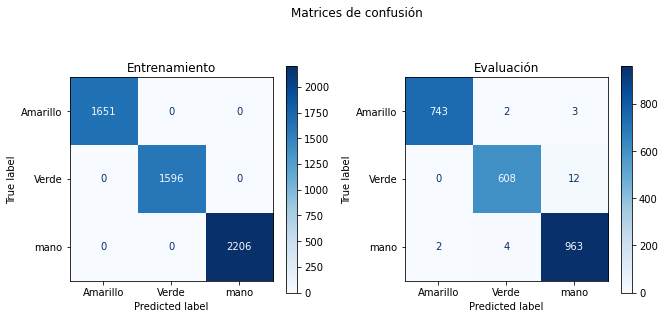



CLASIFICADOR SVC IMÁGENES PEQUEÑAS - GUANTES




GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=11, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 100.0], 'degree': [3, 5],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,C,gamma,degree,mean_accuracy,standar_deviation,rank
4,10,scale,3,0.918403,0.004037,1
6,10,scale,5,0.918403,0.004037,1
8,100,scale,3,0.917052,0.007798,3
10,100,scale,5,0.917052,0.007798,3
9,100,auto,3,0.916860,0.006754,5
11,100,auto,5,0.916860,0.006754,5
5,10,auto,3,0.897569,0.006615,7
7,10,auto,5,0.897569,0.006615,7
0,1,scale,3,0.893133,0.000984,9
2,1,scale,5,0.893133,0.000984,9



Mejor estimador:
 SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=11, shrinking=True, tol=0.001,
    verbose=False) 


Mejor resultado (accuracy): 0.9184027777777777 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      0.991     0.986     0.989      1977
          si      0.992     0.995     0.993      3207

    accuracy                          0.992      5184
   macro avg      0.991     0.991     0.991      5184
weighted avg      0.992     0.992     0.992      5184

Confusion matrix:
 [[1950   27]
 [  17 3190]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

          no      0.935     0.904     0.919       793
          si      0.948     0.965     0.956      1430

    accuracy                          0.943      

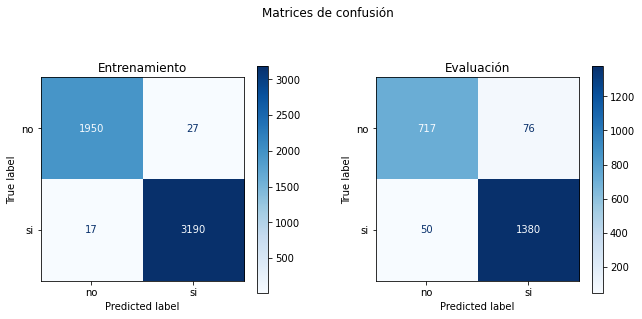



CLASIFICADOR SVC IMÁGENES PEQUEÑAS - COLOR




GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=11, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 100.0], 'degree': [3, 5],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



Tabla comparativa de parámetros del modelo:



,C,gamma,degree,mean_accuracy,standar_deviation,rank
4,10,scale,3,0.898148,0.012862,1
6,10,scale,5,0.898148,0.012862,1
9,100,auto,3,0.896219,0.013409,3
11,100,auto,5,0.896219,0.013409,3
8,100,scale,3,0.894483,0.011806,5
10,100,scale,5,0.894483,0.011806,5
5,10,auto,3,0.875193,0.008781,7
7,10,auto,5,0.875193,0.008781,7
0,1,scale,3,0.869406,0.005716,9
2,1,scale,5,0.869406,0.005716,9



Mejor estimador:
 SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=11, shrinking=True, tol=0.001,
    verbose=False) 


Mejor resultado (accuracy): 0.898148148148148 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      0.997     0.994     0.995      1579
       Verde      0.990     0.989     0.990      1628
        mano      0.989     0.993     0.991      1977

    accuracy                          0.992      5184
   macro avg      0.992     0.992     0.992      5184
weighted avg      0.992     0.992     0.992      5184

Confusion matrix:
 [[1569    5    5]
 [   2 1610   16]
 [   3   11 1963]] 



Metricas sobre el conjunto de evaluación:
              precision    recall  f1-score   support

    Amarillo      0.923     0.926     0.924       714
       Verde      0.913

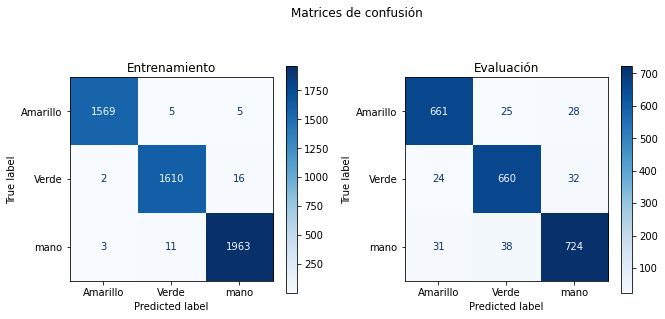

In [28]:
svc_parameters = {
    'C': [1.0, 10.0, 100.0],  
    'gamma': ['scale', 'auto'],
    'degree': [3, 5],
    'kernel': ['rbf']
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    print("\n\nCLASIFICADOR SVC PARA IMÁGENES GRANDES - GUANTES\n")
    process_customized_model(SVC(random_state=11), svc_parameters, X_G, y_G_guantes) # Accuracy: 0.9917473585553381

    print("\n\nCLASIFICADOR SVC PARA IMÁGENES GRANDES - COLOR\n")
    process_customized_model(SVC(random_state=11), svc_parameters, X_G, y_G_color)   # Accuracy: 0.9888135300413182

    print("\n\nCLASIFICADOR SVC PARA IMÁGENES PEQUEÑAS - GUANTES\n\n")
    process_customized_model(SVC(random_state=11), svc_parameters, X_P, y_P_guantes) # Accuracy: 0.9184027777777777

    print("\n\nCLASIFICADOR SVC PARA IMÁGENES PEQUEÑAS - COLOR\n\n")
    process_customized_model(SVC(random_state=11), svc_parameters, X_P, y_P_color)   # Accuracy: 0.898148148148148


# Random Forest

## Random Forest - Modelo por Defecto

In [29]:
print("\nMODELO RANDOM FOREST CON PARÁMETROS POR DEFECTO:\n\n",RandomForestClassifier(random_state=11,n_jobs=-1).get_params)


MODELO CON PARÁMETROS POR DEFECTO:

 <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)>




CLASIFICADOR RANDOM FOREST PARA IMÁGENES GRANDES - GUANTES

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      1.000     1.000     1.000      2206
          si      1.000     1.000     1.000      3247

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[2206    0]
 [   0 3247]] 


Accuracy de evaluación: 0.9726144629867352

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.980     0.954     0.967       969
          si      0.968     0.986     0.977      1368

    accuracy                          0.973      2337
   macro avg      0.974     0.970     0.972      2337
weighted avg      0.973     0.973     0.973      2337

Confusion matrix:
 [[ 924   45]
 [  19 1349]] 




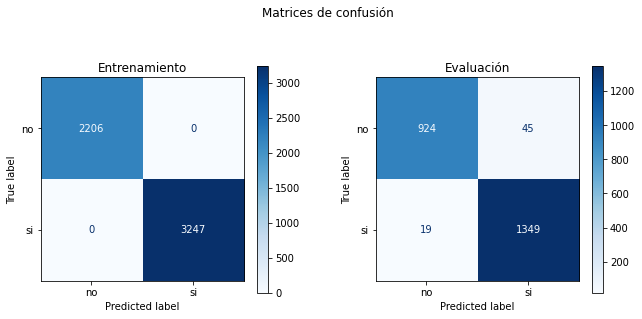



Features que mas influyeron en el aprendizaje del algoritmo:



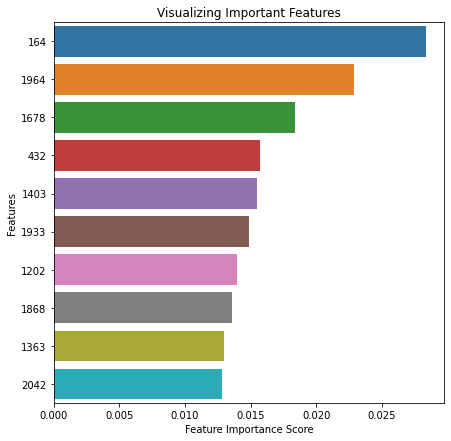



CLASIFICADOR RANDOM FOREST PARA IMÁGENES GRANDES - COLOR

Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1651
       Verde      1.000     1.000     1.000      1596
        mano      1.000     1.000     1.000      2206

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confusion matrix:
 [[1651    0    0]
 [   0 1596    0]
 [   0    0 2206]] 


Accuracy de evaluación: 0.9567821994009413

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.958     0.953     0.956       748
       Verde      0.956     0.940     0.948       620
        mano      0.956     0.970     0.963       969

    accuracy                          0.957      2337
   macro avg      0.957     0.955     0.956      2337
weighted avg      0.957 

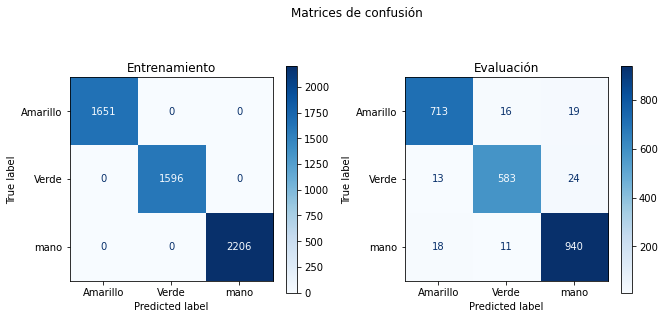



Features que mas influyeron en el aprendizaje del algoritmo:



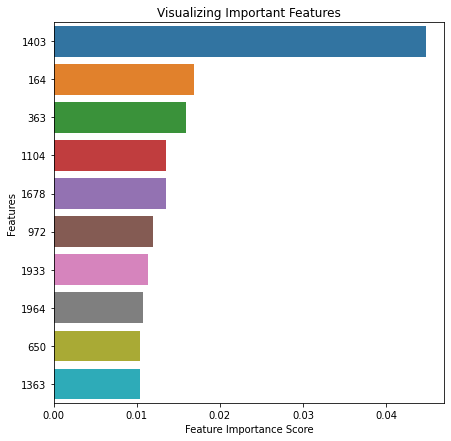



CLASIFICADOR RANDOM FOREST PARA IMÁGENES PEQUEÑAS - GUANTES


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

          no      1.000     1.000     1.000      1977
          si      1.000     1.000     1.000      3207

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighted avg      1.000     1.000     1.000      5184

Confusion matrix:
 [[1977    0]
 [   0 3207]] 


Accuracy de evaluación: 0.8735942420152947

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

          no      0.912     0.715     0.801       793
          si      0.859     0.962     0.907      1430

    accuracy                          0.874      2223
   macro avg      0.885     0.838     0.854      2223
weighted avg      0.878     0.874     0.870      2223

Confusion matrix:
 [[ 567  226]
 [  55 1375]] 




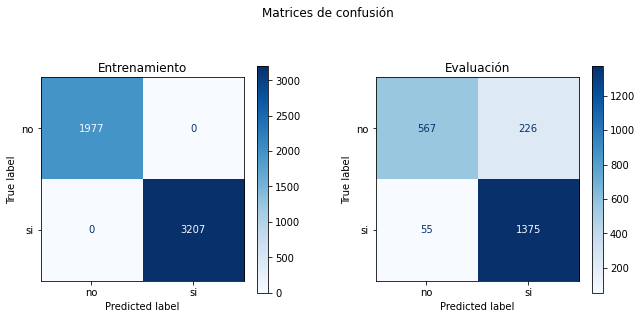



Features que mas influyeron en el aprendizaje del algoritmo:



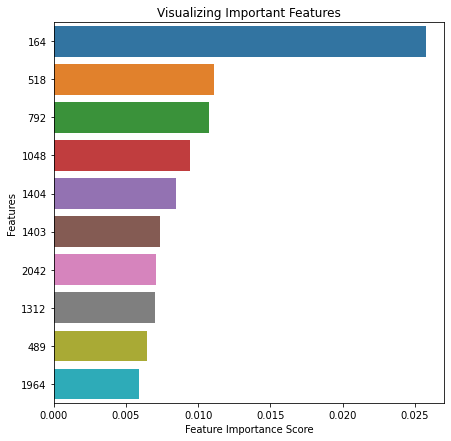



CLASIFICADOR RANDOM FOREST PARA IMÁGENES PEQUEÑAS - COLOR


Metricas sobre el conjunto de entrenamiento:
              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1579
       Verde      1.000     1.000     1.000      1628
        mano      1.000     1.000     1.000      1977

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighted avg      1.000     1.000     1.000      5184

Confusion matrix:
 [[1579    0    0]
 [   0 1628    0]
 [   0    0 1977]] 


Accuracy de evaluación: 0.8200629779577148

Métricas sobre el conjunto de evaluación:

              precision    recall  f1-score   support

    Amarillo      0.890     0.815     0.851       714
       Verde      0.771     0.814     0.792       716
        mano      0.809     0.830     0.819       793

    accuracy                          0.820      2223
   macro avg      0.823     0.820     0.821      2223
weighted avg      0.82

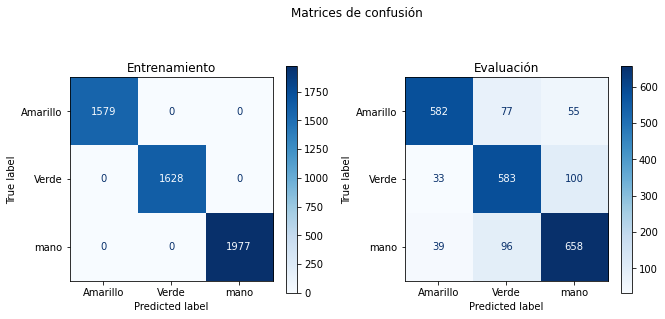



Features que mas influyeron en el aprendizaje del algoritmo:



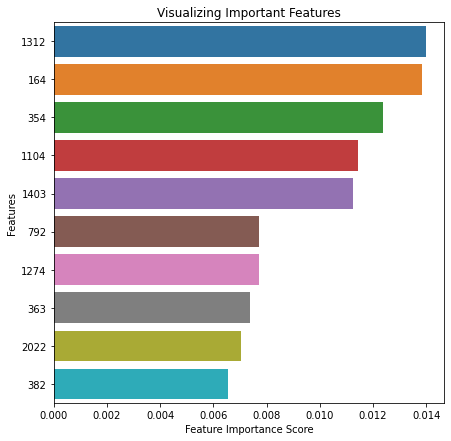

In [28]:
print("\n\nCLASIFICADOR RANDOM FOREST PARA IMÁGENES GRANDES - GUANTES\n")
process_default_model(RandomForestClassifier(random_state=11,n_jobs=-1), X_G, y_G_guantes) # Accuracy: 0.9726144629867352

print("\n\nCLASIFICADOR RANDOM FOREST PARA IMÁGENES GRANDES - COLOR\n")
process_default_model(RandomForestClassifier(random_state=11,n_jobs=-1), X_G, y_G_color)   # Accuracy: 0.9567821994009413

print("\n\nCLASIFICADOR RANDOM FOREST PARA IMÁGENES PEQUEÑAS - GUANTES\n\n")
process_default_model(RandomForestClassifier(random_state=11,n_jobs=-1), X_P, y_P_guantes) # Accuracy: 0.8735942420152947

print("\n\nCLASIFICADOR RANDOM FOREST PARA IMÁGENES PEQUEÑAS - COLOR\n\n")
process_default_model(RandomForestClassifier(random_state=11,n_jobs=-1), X_P, y_P_color)   # Accuracy: 0.8200629779577148


## Random Forest - Modelo Personalizado



CLASIFICADOR PERSONALIZADO PARA IMÁGENES GRANDES - GUANTES



GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                                  



Tabla comparativa de parámetros del modelo:



,n_estimators,criterion,min_samples_split,min_samples_leaf,mean_accuracy,standar_deviation,rank
23,200,entropy,5,2,0.969374,0.001819,1
20,100,entropy,5,2,0.969008,0.000685,2
6,150,gini,5,2,0.968458,0.001439,3
3,200,gini,2,2,0.968091,0.001191,4
16,100,entropy,2,2,0.968091,0.001191,4
7,200,gini,5,2,0.968091,0.001355,6
5,120,gini,5,2,0.967908,0.000255,7
22,150,entropy,5,2,0.967907,0.002125,8
19,200,entropy,2,2,0.967907,0.001379,9
0,100,gini,2,2,0.967724,0.001697,10



Mejor estimador:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False) 


Mejor resultado (accuracy): 0.9693744186379746 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      1.000     1.000     1.000      2206
          si      1.000     1.000     1.000      3247

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighted avg      1.000     1.000     1.000      5453

Confus

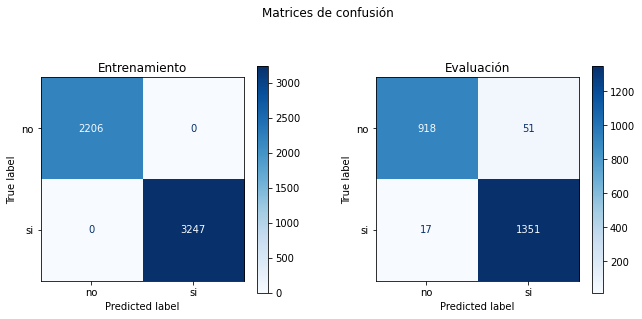



Features que mas influyeron en el aprendizaje del algoritmo:



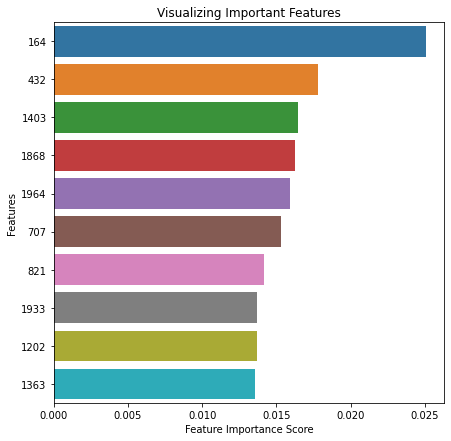



CLASIFICADOR PERSONALIZADO PARA IMÁGENES GRANDES - COLOR



GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                                  



Tabla comparativa de parámetros del modelo:



,n_estimators,criterion,min_samples_split,min_samples_leaf,mean_accuracy,standar_deviation,rank
19,200,entropy,2,2,0.963691,0.003668,1
23,200,entropy,5,2,0.963140,0.002937,2
18,150,entropy,2,2,0.962590,0.004108,3
21,120,entropy,5,2,0.961857,0.003422,4
3,200,gini,2,2,0.961856,0.002986,5
20,100,entropy,5,2,0.961490,0.003984,6
17,120,entropy,2,2,0.961490,0.003881,6
22,150,entropy,5,2,0.961306,0.002982,8
16,100,entropy,2,2,0.961306,0.002464,9
7,200,gini,5,2,0.961123,0.003811,10



Mejor estimador:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False) 


Mejor resultado (accuracy): 0.9636906178234774 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1651
       Verde      1.000     1.000     1.000      1596
        mano      1.000     1.000     1.000      2206

    accuracy                          1.000      5453
   macro avg      1.000     1.000     1.000      5453
weighte

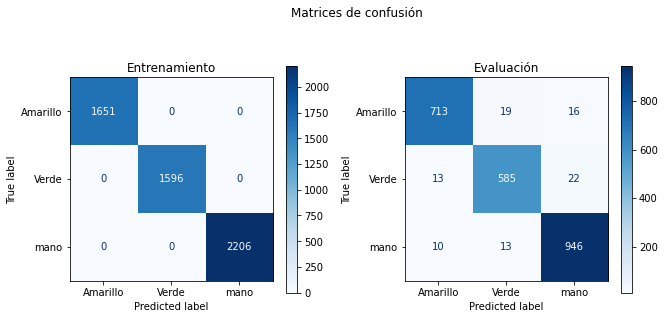



Features que mas influyeron en el aprendizaje del algoritmo:



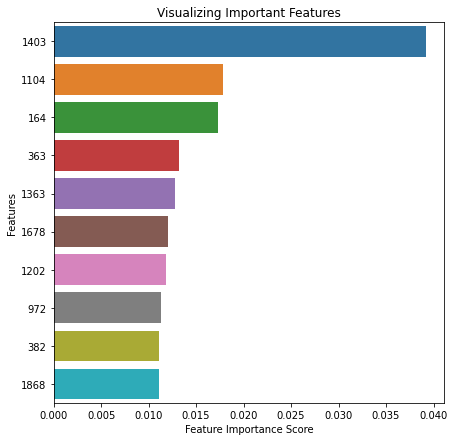



CLASIFICADOR PERSONALIZADO PARA IMÁGENES PEQUEÑAS - GUANTES



GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                                  



Tabla comparativa de parámetros del modelo:



,n_estimators,criterion,min_samples_split,min_samples_leaf,mean_accuracy,standar_deviation,rank
23,200,entropy,5,2,0.852045,0.003319,1
18,150,entropy,2,2,0.848958,0.005921,2
16,100,entropy,2,2,0.848765,0.008404,3
17,120,entropy,2,2,0.848573,0.006638,4
19,200,entropy,2,2,0.848380,0.008544,5
20,100,entropy,5,2,0.848380,0.002874,6
21,120,entropy,5,2,0.848380,0.002060,6
22,150,entropy,5,2,0.847994,0.004235,8
3,200,gini,2,2,0.847415,0.007325,9
28,100,entropy,5,7,0.847222,0.003098,10



Mejor estimador:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False) 


Mejor resultado (accuracy): 0.8520447530864198 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

          no      1.000     1.000     1.000      1977
          si      1.000     1.000     1.000      3207

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighted avg      1.000     1.000     1.000      5184

Confus

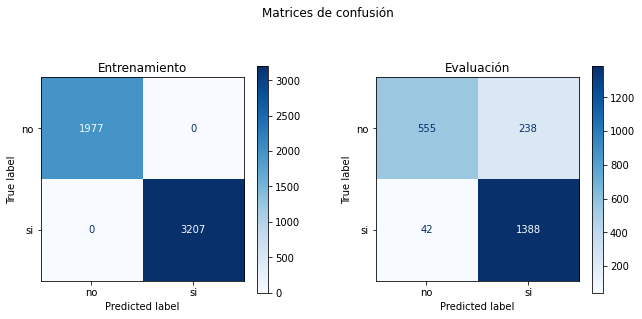



Features que mas influyeron en el aprendizaje del algoritmo:



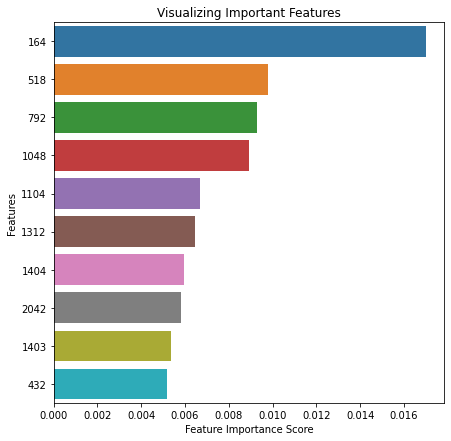



CLASIFICADOR PERSONALIZADO PARA IMÁGENES PEQUEÑAS - COLOR



GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                                  



Tabla comparativa de parámetros del modelo:



,n_estimators,criterion,min_samples_split,min_samples_leaf,mean_accuracy,standar_deviation,rank
23,200,entropy,5,2,0.821952,0.006415,1
19,200,entropy,2,2,0.821566,0.007682,2
22,150,entropy,5,2,0.821373,0.009915,3
7,200,gini,5,2,0.819830,0.003319,4
18,150,entropy,2,2,0.819444,0.007088,5
26,150,entropy,2,7,0.818480,0.005052,6
3,200,gini,2,2,0.818480,0.005183,6
30,150,entropy,5,7,0.818480,0.005052,6
6,150,gini,5,2,0.817130,0.009199,9
17,120,entropy,2,2,0.816937,0.008257,10



Mejor estimador:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False) 


Mejor resultado (accuracy): 0.8219521604938271 


Metricas sobre el conjunto de entrenamiento: 

              precision    recall  f1-score   support

    Amarillo      1.000     1.000     1.000      1579
       Verde      1.000     1.000     1.000      1628
        mano      1.000     1.000     1.000      1977

    accuracy                          1.000      5184
   macro avg      1.000     1.000     1.000      5184
weighte

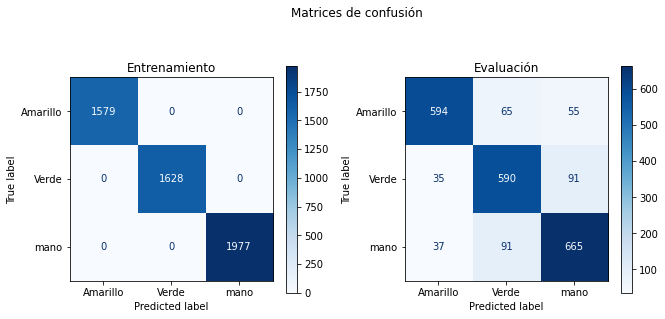



Features que mas influyeron en el aprendizaje del algoritmo:



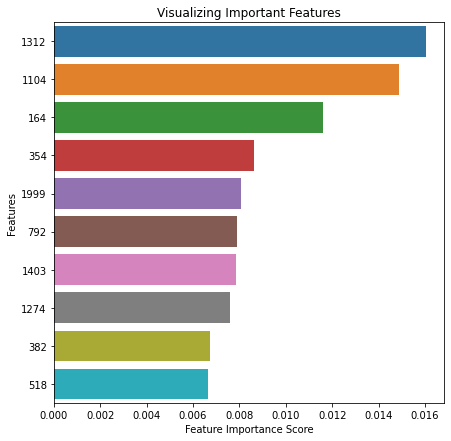

In [98]:
rf_parameters = {
    'n_estimators' : [100,120,150,200],
    'criterion'    : ['gini','entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 7],
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    print("\n\nCLASIFICADOR RANDOM FOREST PERSONALIZADO PARA IMÁGENES GRANDES - GUANTES\n")
    process_customized_model(RandomForestClassifier(random_state=11,n_jobs=-1), rf_parameters, X_G, y_G_guantes) # Accuracy: 0.9693744186379746

    print("\n\nCLASIFICADOR RANDOM FOREST PERSONALIZADO PARA IMÁGENES GRANDES - COLOR\n")
    process_customized_model(RandomForestClassifier(random_state=11,n_jobs=-1), rf_parameters, X_G, y_G_color)   # Accuracy: 0.9636906178234774 

    print("\n\nCLASIFICADOR RANDOM FOREST PERSONALIZADO PARA IMÁGENES PEQUEÑAS - GUANTES\n")
    process_customized_model(RandomForestClassifier(random_state=11,n_jobs=-1), rf_parameters, X_P, y_P_guantes) # Accuracy: 0.8520447530864198

    print("\n\nCLASIFICADOR RANDOM FOREST PERSONALIZADO PARA IMÁGENES PEQUEÑAS - COLOR\n")
    process_customized_model(RandomForestClassifier(random_state=11,n_jobs=-1), rf_parameters, X_P, y_P_color)   # Accuracy: 0.8219521604938271


<br>

# ANÁLISIS DE LOS RESULTADOS
---

### Para entrenar los modelos utilizamos el dataset con todas las imágenes disponibles con todos los features (2048) ya que si bien utilizando sólo los features más importantes obteníamos buenos resultados, incluyendo a todos el resultado era muy superior. 
### Para evaluar los modelos elegimos como métrica la Accuracy aunque también podríamos haber usado Precision. Ambas son buenas para algoritmos de clasificación. Un valor más alto significa un mejor resultado.

In [ ]:
results = [
  ['G','guantes','SVC',0.9917473585553381],
  ['G','guantes','KNN',0.9781771501925546],
  ['G','guantes','RF',0.9726144629867352],
  ['G','color','SVC',0.9888135300413182],
  ['G','color','KNN',0.965340179717586],
  ['G','color','RF',0.9636906178234774],
  ['P','guantes','SVC',0.9194781826360774],
  ['P','guantes','RF',0.8735942420152947],
  ['P','guantes','KNN',0.8529014844804319],
  ['P','color','SVC',0.898148148148148],
  ['P','color','RF',0.8219521604938271],
  ['P','color','KNN',0.8047683310841206]]

df_R = pd.DataFrame(results,columns=['Size','Target','Model','Accuracy'])
df_R.set_index(['Size','Target'],inplace=True)
df_R

Model  Accuracy
Size Target                 
G    guantes   SVC  0.991747
     guantes   KNN  0.978177
     guantes    RF  0.972614
     color     SVC  0.988814
     color     KNN  0.965340
     color      RF  0.963691
P    guantes   SVC  0.919478
     guantes    RF  0.873594
     guantes   KNN  0.852901
     color     SVC  0.898148
     color      RF  0.821952
     color     KNN  0.804768

#### Se observa que **SVC** fue el mejor modelo, tanto para clasificación binaria (guantes) como para clasificación multiclase (color), para imágenes grandes (G) y para imágenes pequeñas (P).

#### Para la clasificación de guantes en imágenes grandes se obtuvo una Accuracy superior al 99%, y en las imágenes pequeñas fue de casi 92%.

#### Para la clasificación por color en imágenes grandes se obtuvo una Accuracy de casi 92%, y en las imágenes pequeñas fue de casi 90%.

### Por otro lado, fue muy interesante poder visualizar en el modelo de Random Forest las features más significativas para el aprendizaje del modelo. Esas features coinciden con las encontradas en los análisis realizados previamente.   